In [1]:
import dissociation as ds

import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
import optax

from functools import partial 

plt.style.use("./style.mplstyle")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
train, train_labels, validate, validate_labels = ds.load_mnist()
samples_n = 60000
train = train[..., :samples_n]
train_labels = train_labels[..., :samples_n]

In [3]:
in_dim = 28 * 28
hidden_dim = 1024
out_dim = 10

batch_size = 256

epochs = 25
lr = 0.8

def init_layer(key, out_dim, in_dim):
    return jax.random.normal(key, (out_dim, in_dim)) * np.sqrt(0.01 / in_dim)

@jax.jit
def relu(x):
    return np.maximum(0, x)
    
@jax.jit
def forward(params, xs):
    w1, w2 = params
    return w2 @ relu(w1 @ xs)

@jax.jit
def cross_entropy(params, xs, ys):
    logits = forward(params, xs)
    return -np.mean(np.sum(ys * jax.nn.log_softmax(logits), axis=0))

@jax.jit
def update(params, xs, ys, lr):
    loss, grads = jax.value_and_grad(cross_entropy)(params, xs, ys)
    return loss, [(w - lr * dw) for w, dw in zip(params, grads)]

@jax.jit
def evaluate(params, xs, ys):
    logits = forward(params, xs)
    return np.mean(np.argmax(logits, axis=0) == np.argmax(ys, axis=0))


rng, key1, key2 = jax.random.split(jax.random.PRNGKey(1), 3)

params = [init_layer(key1, hidden_dim, in_dim), init_layer(key2, out_dim, hidden_dim)]
losses = []
evals = []
n = train.shape[-1]
for epoch in range(epochs):
    rng, key = jax.random.split(rng)
    idxs = jax.random.choice(key, n, (n // batch_size, batch_size), replace=False)
    for i, idx in enumerate(idxs):
        loss, params = update(params, train[..., idx], train_labels[..., idx], lr)
        losses.append(loss)
        if i % 100 == 0:
            evals.append(evaluate(params, validate, validate_labels))

Train 0.99865 Validate 0.9826


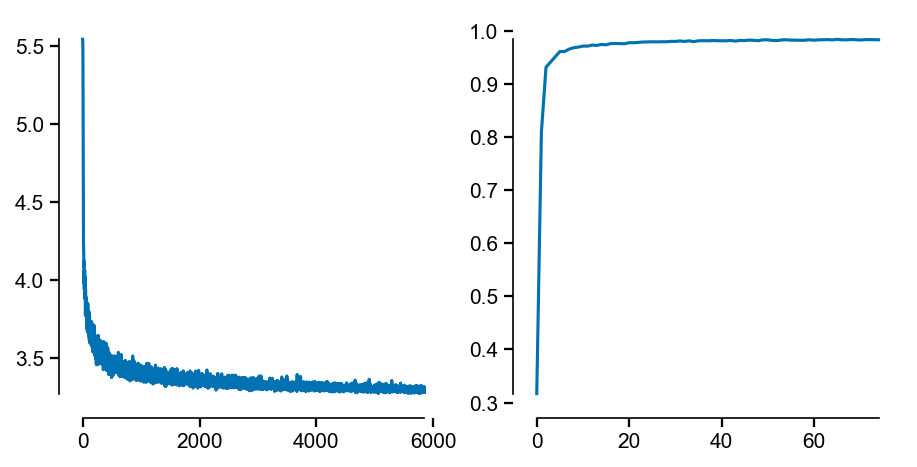

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].plot(losses)
axs[1].plot(evals)
print("Train", evaluate(params, train, train_labels), "Validate", evaluate(params, validate, validate_labels))

In [5]:
xs = train[..., :1024].copy()
elephant = np.asarray(iio.imread("../figures/fig5/elephants.png"))[:, :, 0]
elephant = elephant / (np.max(elephant) / 0.98) + 0.02

In [6]:
def augmented_lagrangian(x0, f, g, lam, mu, lr=1e-4, inner_iter=50, outer_iter=10):
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(x0)

    def inner_minimisation(state, lam, mu):
        x, opt_state = state

        opt_state = optimizer.init(x0)

        def inner_step(i, state):
            x, opt_state = state
            loss = lambda x: f(x) + np.sum(lam * g(x)) + (mu / 2) * np.sum(g(x)**2)
            updates, opt_state = optimizer.update(jax.grad(loss)(x), opt_state, x)
            x = optax.apply_updates(x, updates)
            return x, opt_state

        return jax.lax.fori_loop(0, inner_iter, inner_step, (x, opt_state))

    def outer_step(state):
        x, lam, mu, opt_state, i = state
        x, opt_state = inner_minimisation((x, opt_state), lam, mu)
        lam = lam + mu * g(x)

        l1 = forward([params[0], params[1]], train)
        l2 = forward([params[0] + x, params[1]], train) 
        rr = np.sum(np.argmax(l1, axis=0) == np.argmax(l2, axis=0)) / samples_n
        ev = evaluate([params[0] + x, params[1]], train, train_labels)
        jax.debug.print("{i}: (mu={mu}): {error} with {ev} and {acc}", i=i, mu=mu, error=f(x), ev=ev, acc=rr)
        return x, lam, mu, opt_state, i + 1

    def condition(state):
        x, _, _, _, i = state
        l1 = forward([params[0], params[1]], train)
        l2 = forward([params[0] + x, params[1]], train) 
        return ~np.all(np.argmax(l1, axis=0) == np.argmax(l2, axis=0)) | (i < 50)

    return jax.lax.while_loop(condition, outer_step, (x0, lam, mu, opt_state, 0))

augmented_lagrangian = jax.jit(augmented_lagrangian, static_argnums=[1, 2])

In [7]:
w1, w2 = params
target = elephant

tau = .25

x0 = np.zeros_like(w1)
f = lambda delta_w1: np.linalg.norm(relu((w1 + delta_w1) @ xs) - target, ord="fro")**2 / target.shape[-1]

def g(delta_w1):
    perturbed_probs = jax.nn.softmax(forward((w1 + delta_w1, w2), train) / tau, axis=0)
    original_probs = jax.nn.softmax(forward((w1, w2), train) / tau, axis=0)
    return (perturbed_probs - original_probs) / xs.shape[-1]

lam = np.zeros_like(forward((w1, w2), train))
mu = 150000.

print(f(x0), np.sum(lam * g(x0)), (mu / 2) * np.sum(g(x0)**2))

delta_w1, lam, mu, _, _ = augmented_lagrangian(x0, f, g, lam, mu, lr=1e-4, inner_iter=250, outer_iter=150)

print(f(delta_w1), np.sum(lam * g(delta_w1)), (mu / 2) * np.sum(g(delta_w1)**2))

344.2406 0.0 0.0
0: (mu=150000.0): 170.8548126220703 with 0.9986000061035156 and 0.9999499917030334
1: (mu=150000.0): 138.73687744140625 with 0.9986333250999451 and 0.999916672706604
2: (mu=150000.0): 125.42156219482422 with 0.9986333250999451 and 0.9999499917030334
3: (mu=150000.0): 115.36283874511719 with 0.9985833168029785 and 0.9999333620071411
4: (mu=150000.0): 107.77798461914062 with 0.9986166954040527 and 0.9999666810035706
5: (mu=150000.0): 103.93167877197266 with 0.9986166954040527 and 0.9999666810035706
6: (mu=150000.0): 100.11811828613281 with 0.9986500144004822 and 1.0
7: (mu=150000.0): 96.53903198242188 with 0.9986833333969116 and 0.9999666810035706
8: (mu=150000.0): 94.06437683105469 with 0.9986667037010193 and 0.9999833703041077
9: (mu=150000.0): 91.55010986328125 with 0.9986667037010193 and 0.9999833703041077
10: (mu=150000.0): 89.7127685546875 with 0.9986333250999451 and 0.9999833703041077
11: (mu=150000.0): 87.59747314453125 with 0.9986500144004822 and 1.0
12: (mu=150

In [8]:
x = np.linspace(-1, 1, hidden_dim)
y = np.linspace(-1, 1, hidden_dim)
xx, yy = np.meshgrid(x, y)

r = np.sqrt(xx**2 + yy**2)
theta = np.arctan2(yy, xx)

pattern = np.sin(10 * theta)

pattern -= pattern.min()
pattern /= pattern.max()

pattern = (pattern + pattern.T) / 2 + 0.1

In [9]:
expand_by = 1024

w1 = params[0].copy()

nuisance = jax.random.normal(jax.random.PRNGKey(1), (expand_by, w1.shape[1])) * 0.01
a = np.ones((hidden_dim + expand_by, ))

ps = [nuisance, a]

optimizer = optax.adam(learning_rate=2e-4)
opt_state = optimizer.init(ps)

def optim(params, s):
    nuisance, a = params
    w1_ = np.vstack([w1, nuisance]) * a[:, np.newaxis]
    h = relu(w1_ @ xs)
    return 0.5 * np.linalg.norm(h.T @ h - pattern * s)**2 / 1024    

grad = jax.jit(jax.grad(optim))

losses = []
steps = 5000
for i in range(steps):
    s = 100.
    updates, opt_state = optimizer.update(grad(ps, s), opt_state, ps)
    ps = optax.apply_updates(ps, updates)
    ps[1] = np.clip(ps[1], a_min=1e-6)

nuisance, a = ps
w1_ = np.vstack([w1, nuisance]) * a[:, np.newaxis]

w2_ = np.hstack([w2, np.zeros((out_dim, expand_by))]) * (1./a[np.newaxis, :])
evaluate([w1_, w2_], train, train_labels)

Array(0.99865, dtype=float32)

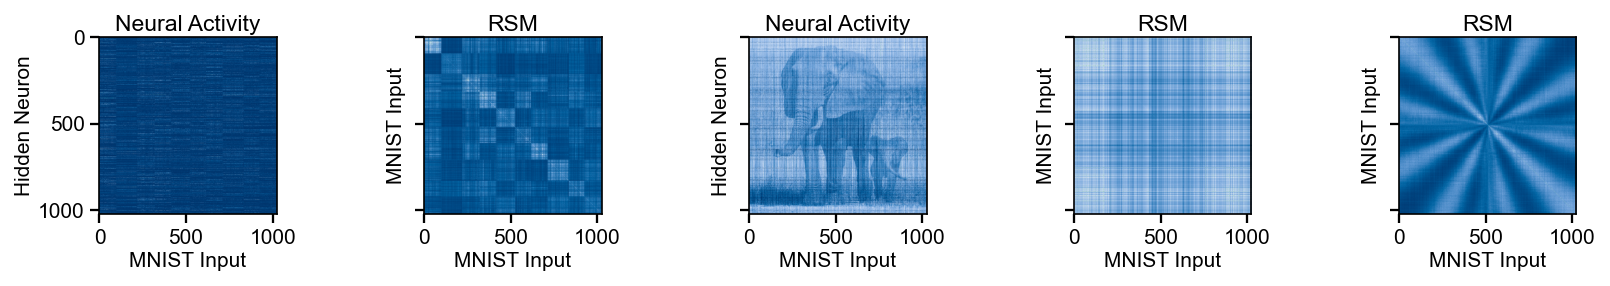

In [10]:
labels = np.argmax(train_labels[:, :1024], axis=0)
sorted_indices = np.argsort(labels)
xs_sorted = xs[..., sorted_indices]


fig, axs = plt.subplots(1, 5, figsize=(3.8*1.6*1.8, 1.12*1.6))
axs = axs.flatten()

h = relu(params[0] @ xs_sorted)

ax = axs[0]
ax.imshow(h)
ax.set_title("Neural Activity")
ax.set_ylabel("Hidden Neuron")

ax = axs[1]
ax.imshow(h.T @ h)
ax.set_title("RSM")
ax.set_ylabel("MNIST Input")

h = relu((params[0] + delta_w1) @ xs)

ax = axs[2]
ax.imshow(h)
ax.set_title("Neural Activity")
ax.set_ylabel("Hidden Neuron")

ax = axs[3]
ax.imshow(h.T @ h)
ax.set_title("RSM")
ax.set_ylabel("MNIST Input")

h = relu(w1_ @ xs)

ax = axs[4]
ax.imshow(h.T @ h)
ax.set_title("RSM")
ax.set_ylabel("MNIST Input")

for i in range(5):
    axs[i].set_xlabel("MNIST Input")
    if i > 0:
        axs[i].set_yticklabels([])
    axs[i].spines['top'].set_visible(True)
    axs[i].spines['right'].set_visible(True)
    axs[i].set_xticks([0, 500, 1000])
    axs[i].set_yticks([0, 500, 1000])

plt.savefig("../figures/fig5/activities-and-rsms.svg", dpi=300)    